In [10]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter

Declaramos las constantes del problema

In [11]:
w = 2.6617e-6 #s^-1
G = 6.67e-11
d_TL = 3.844e8
M_T = 5.9736e24
M_L = 0.07349e24

R_T = 6.378160e6
R_L = 1.7374e6

delta = G*M_T/d_TL**3
nu = M_L/M_T

v_02 = 2*G*M_T/R_T

n_interation = 10e6

Asignamos la orbita para la Luna, y definimos las funciones con las ecuaciones diferenciales

In [12]:

def polar_to_cart (vec):
    x = vec[0] * np.cos(vec[1])
    y = vec[0] * np.sin(vec[1])
    return np.array([x, y])

Teniendo en cuenta que los vectores tienen la forma $\text{vec}_\text{Cohete} = (r, \phi, p_r, p_{\phi})$

In [13]:
@jit(nopython = True)
def function (vec_Cohete, t):
    r_prime = np.power(1+vec_Cohete[0]**2-2*vec_Cohete[0]*np.cos(vec_Cohete[1]-w*t), 1/2)
    
    r_dot = vec_Cohete[2]
    phi_dot = vec_Cohete[3]/vec_Cohete[0]**2
    pr_dot = vec_Cohete[3]**2/vec_Cohete[0]**3 - delta * (1/vec_Cohete[0]**2 + nu*(vec_Cohete[0]- np.cos(vec_Cohete[1]-w*t))/vec_Cohete[0]**3)
    pphi_dot = -delta*nu*vec_Cohete[0]*np.sin(vec_Cohete[1]-w*t)/r_prime**3
    
    return np.array([r_dot, phi_dot, pr_dot, pphi_dot])

Algoritmo para Runge-Kutta

In [14]:
@jit(nopython = True)
def Runge_Kutta (vec_Cohete, h, t):
    k_1 = h*function(vec_Cohete, t)
    k_2 = h*function(vec_Cohete + k_1/2, t + h/2)
    k_3 = h*function(vec_Cohete + k_2/2, t + h/2)
    k_4 = h*function(vec_Cohete + k_3, t + h)

    return vec_Cohete + (k_1 + k_2 + k_3 + k_4)/6

Añadimos una función para determinar el paso $h$, que tomar en cada momento

In [15]:
def compute_h(vec_Cohete, t, h):
    h_0 = 60
    epsilon_max = h_0**5
    s = 100
    while (s > 2):
        y_h2 = Runge_Kutta(vec_Cohete, h/2, t)
        y_h = Runge_Kutta(vec_Cohete, h, t)
        epsilon = np.max(16*np.abs(y_h2-y_h)/15)

        s = np.max([(epsilon/epsilon_max**0.2, 1e-8)])
        h_max = h/s

        if(s > 2):
            h = h_max
        else:
            h = 2*h
            return y_h2, h

In [16]:
@jit(nopython = True)
def inital_cond():
    return np.array([R_T/d_TL, 0, v_02/(2*d_TL), 0])

In [17]:
@jit(nopython = True)
def run_code_h_cte ():
    vec_Cohete_total = np.zeros((int(n_interation), 4))
    vec_Cohete_total[0] = inital_cond()
    t = 0
    h = 60
    for i in range(int(n_interation)-1):
        vec_Cohete_total[i+1] = Runge_Kutta(vec_Cohete_total[i], h, t)
        t = t+ h
    return vec_Cohete_total


def run_code():
    vec_Cohete_total = np.zeros((int(n_interation), 4))
    vec_Cohete_total[0] = inital_cond()
    t = 0
    h = 60
    for i in range(int(n_interation)-1):
        vec_Cohete_total[i+1], h = compute_h(vec_Cohete_total[i], t, h)
        t = t+ h
    return vec_Cohete_total

In [18]:
vec_Cohete = run_code_h_cte()
pos_cohete = polar_to_cart(np.array([vec_Cohete[:,0]*d_TL, vec_Cohete[:,1]]))

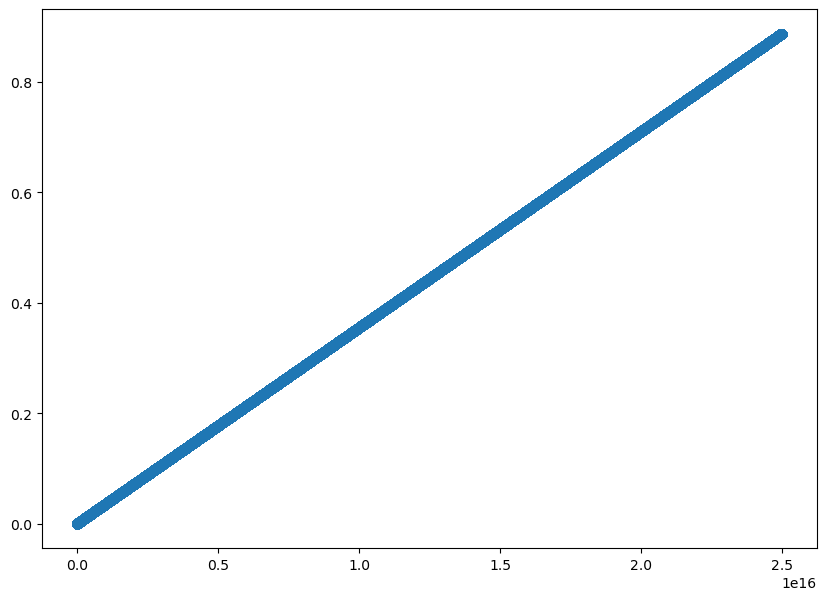

In [19]:
fig=plt.figure(figsize=(10,7)) #Size of the plot
ax=fig.add_subplot(111)

plt.scatter(pos_cohete[0], pos_cohete[1])